In [1]:
pwd

'/Users/huntersylvester/Desktop/UMMC/Research/Moradi'

In [108]:
import fnmatch
import glob
import os
from natsort import natsorted
from PIL import Image
import numpy as np

# Empty list to store numpy arrays
image_list = []
y = []

# lets us know number of images in that file
dirpath = "/Users/huntersylvester/Desktop/UMMC/Research/Moradi/sample_knee_mri_localization/9009067_10287112_R_Progressed"
num_layers = len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))
print(num_layers)


directory = "/Users/huntersylvester/Desktop/UMMC/Research/Moradi/knee_mri_localization"
for filename in glob.iglob(f"{directory}/*"):
    i = 0
    os.chdir(filename)
    x = filename.find('_NotProgressed')  # Will give -1 if phrase not in string
    if x > 0:
        y.append(0)  # non progressed 0
    else:
        y.append(1)  # progressed 1
    image_patient = []
    for file in natsorted(glob.glob("*.jpg")):
        i += 1
        im = Image.open(file)
        image_patient.append(np.array(im))
        if i != num_layers:
            pass
        else:
            print(f"number of layers: {i}")
    image_list.append(np.array(image_patient))

image_list = np.array(image_list, dtype=object)
# image_list = np.array(image_list, dtype=object)

print(len(image_list), len(image_list[0]), len(image_list[0][0]))
print(type(image_list), type(image_list[0]), type(image_list[0][0]))
print(y)

10
number of layers: 10
number of layers: 10
number of layers: 10
number of layers: 10
number of layers: 10
number of layers: 10
number of layers: 10
8 11 384
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
[1, 0, 0, 0, 0, 0, 1, 1]


In [27]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [109]:
len(image_list[1]) # We get 11 layers for one patient same if we do len(image_list[2])
image_list[1][1] # This is each image in a numpy for patient 1
y[:3] # These are the labels for the first three patients so we should see 1 0 0 

# For now split data into 50-50 for training and validation
x_train = image_list[:4]
y_train = y[:4]
x_val   = image_list[4:]
y_val   = y[4:]

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 4 and 4.


In [110]:
# We no longer are rotating 
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
#   volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [113]:
# Define data loaders.

# We have to do this or else the third line will not work
############# This currently works as of now as a fix
X_train = tf.convert_to_tensor(list(x_train), dtype=tf.float32)
X_val   = tf.convert_to_tensor(list(x_val), dtype=tf.float32)
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_loader = tf.data.Dataset.from_tensor_slices((list(float(x_train)), y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

ValueError: Can't convert non-rectangular Python sequence to Tensor.

Dimension of the CT scan is: (11, 384, 384, 1)


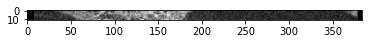

In [105]:
####### As we can see it is labeling y axis as 11 and x axis as 384.  We need 384 x 384 for xy axis.  This is because we have skipped the process scan phase in the code
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")